,Tiempo,Calificacion
0,85.076389,85.0
1,84.675556,85.0
2,79.553889,110.0
3,75.310556,110.0
4,64.958611,110.0


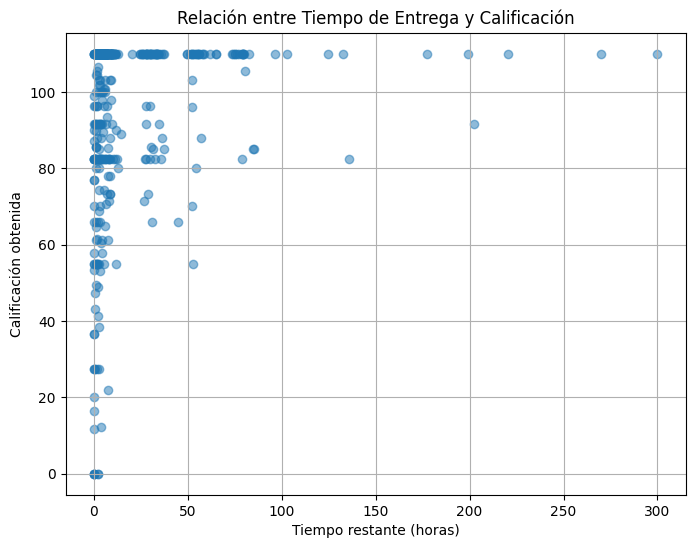

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo CSV
df = pd.read_csv("A1.6 Tiempo de Entrega.csv")

# Convertir las columnas a numéricas, forzando errores a NaN
df_cleaned = df.apply(pd.to_numeric, errors='coerce')

# Eliminar valores no numéricos y cualquier valor mayor a 1000 en ambas columnas
df_cleaned = df_cleaned.dropna()
df_cleaned = df_cleaned[(df_cleaned["Tiempo"] >= 0) & (df_cleaned["Tiempo"] <= 1000)]

# Mostrar las primeras filas del dataframe limpio
display(df_cleaned.head())

# Crear la gráfica de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned["Tiempo"], df_cleaned["Calificacion"], alpha=0.5)
plt.xlabel("Tiempo restante (horas)")
plt.ylabel("Calificación obtenida")
plt.title("Relación entre Tiempo de Entrega y Calificación")
plt.grid(True)
plt.show()


Agrega una línea de
texto en la que generes una predicción sobre qué tipo de algoritmo será el más adecuado
para resolver la tarea (no hay respuestas correctas).

In [15]:
from sklearn.model_selection import train_test_split

# Separar datos en 70% entrenamiento y 30% prueba
train, test = train_test_split(df_cleaned, test_size=0.3, random_state=42)

# Calcular los promedios en cada conjunto
train_mean_tiempo = train["Tiempo"].mean()
test_mean_tiempo = test["Tiempo"].mean()
train_mean_calificacion = train["Calificacion"].mean()
test_mean_calificacion = test["Calificacion"].mean()

# Imprimir resultados
print(f"Promedio de 'Tiempo' en entrenamiento: {train_mean_tiempo:.2f}")
print(f"Promedio de 'Tiempo' en prueba: {test_mean_tiempo:.2f}")
print(f"Promedio de 'Calificación' en entrenamiento: {train_mean_calificacion:.2f}")
print(f"Promedio de 'Calificación' en prueba: {test_mean_calificacion:.2f}")

Promedio de 'Tiempo' en entrenamiento: 18.81
Promedio de 'Tiempo' en prueba: 15.65
Promedio de 'Calificación' en entrenamiento: 95.27
Promedio de 'Calificación' en prueba: 94.28

Los promedios de ambos conjuntos son similares, lo que indica que la división fue equitativa y no introduce sesgos en el análisis.


Los valores promedio de Tiempo y Calificación en los conjuntos de entrenamiento y prueba son similares, lo que indica que la división de los datos fue equilibrada y representa bien la distribución general. Esto es positivo para el análisis, ya que reduce el riesgo de sesgo en el modelo y permite que las predicciones sean más representativas del comportamiento real.

In [17]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Definir el grado del polinomio (ajustable según los datos)
grado_polinomio = 2

# Transformar los datos con características polinomiales
poly = PolynomialFeatures(degree=grado_polinomio)
X_train_poly = poly.fit_transform(train[["Tiempo"]])
X_test_poly = poly.transform(test[["Tiempo"]])

# Entrenar el modelo de regresión polinomial
modelo_polinomial = LinearRegression()
modelo_polinomial.fit(X_train_poly, train["Calificacion"])

# Predecir valores
train_pred = modelo_polinomial.predict(X_train_poly)
test_pred = modelo_polinomial.predict(X_test_poly)

# Evaluar el modelo
r2_train = r2_score(train["Calificacion"], train_pred)
r2_test = r2_score(test["Calificacion"], test_pred)

# Coeficientes del modelo
coeficientes = modelo_polinomial.coef_
intercepto = modelo_polinomial.intercept_

# Imprimir resumen
print(f"Coeficientes del modelo: {coeficientes}")
print(f"Intercepto: {intercepto:.2f}")
print(f"R² en entrenamiento: {r2_train:.4f}")
print(f"R² en prueba: {r2_test:.4f}")


Coeficientes del modelo: [ 0.          0.28646971 -0.00089147]
Intercepto: 91.47
R² en entrenamiento: 0.0513
R² en prueba: 0.0384


El coeficiente del término lineal en la regresión polinomial es positivo, lo que sugiere que entregar más tarde podría estar asociado con una mejor calificación, un resultado inesperado. Sin embargo, dado el bajo R^2 , esta variable no parece estar fuertemente asociada con las calificaciones, lo que indica que otros factores pueden influir más en los resultados.

In [18]:
from sklearn.neighbors import KNeighborsRegressor

# Probar con varios valores de k
k_values = [3, 5, 7, 10]
r2_scores = {}

for k in k_values:
    # Crear y entrenar el modelo KNN
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(train[["Tiempo"]], train["Calificacion"])

    # Predecir en el conjunto de prueba
    test_pred_knn = knn_model.predict(test[["Tiempo"]])

    # Evaluar el modelo
    r2_knn = r2_score(test["Calificacion"], test_pred_knn)
    r2_scores[k] = r2_knn

# Imprimir resultados
for k, r2 in r2_scores.items():
    print(f"R² en prueba para KNN con k={k}: {r2:.4f}")


R² en prueba para KNN con k=3: 0.0081
R² en prueba para KNN con k=5: 0.0568
R² en prueba para KNN con k=7: 0.0619
R² en prueba para KNN con k=10: 0.1277


In [32]:
# Volver a definir la función de regresión segmentada para asegurarnos de que está correctamente inicializada
def regresion_segmentada(X, y, segmentos):
    modelos = []
    for i in range(len(segmentos) - 1):
        # Filtrar los datos en el rango del segmento
        mask = (X >= segmentos[i]) & (X < segmentos[i + 1])
        X_seg = X[mask].values.reshape(-1, 1)
        y_seg = y[mask].values

        if len(X_seg) > 0:  # Evitar errores con segmentos vacíos
            # Transformar a polinomio cuadrático
            poly = PolynomialFeatures(degree=2)
            X_seg_poly = poly.fit_transform(X_seg)

            # Ajustar el modelo
            modelo = LinearRegression()
            modelo.fit(X_seg_poly, y_seg)
            modelos.append((modelo, poly, segmentos[i], segmentos[i + 1]))

    return modelos

# Volver a definir los segmentos y entrenar la regresión segmentada
segmentos = [0, 20, 40, 100]
modelos_segmentados = regresion_segmentada(train["Tiempo"], train["Calificacion"], segmentos)

# Volver a calcular las predicciones de regresión segmentada para asegurarnos de que está definido
test_pred_segmentado = predecir_segmentado(test["Tiempo"], modelos_segmentados)

# Recalcular el RSE para cada modelo con las predicciones corregidas
rse_polinomial = calcular_rse(test["Calificacion"], test_pred)
rse_segmentado = calcular_rse(test["Calificacion"], test_pred_segmentado)
rse_knn = calcular_rse(test["Calificacion"], knn_model.predict(test[["Tiempo"]]))

# Imprimir resultados
print(f"RSE en prueba para regresión polinomial: {rse_polinomial:.4f}")
print(f"RSE en prueba para regresión segmentada: {rse_segmentado:.4f}")
print(f"RSE en prueba para KNN (k=10): {rse_knn:.4f}")

# Comparación de modelos
mejor_modelo = min([(rse_polinomial, "Regresión Polinomial"),
                    (rse_segmentado, "Regresión Segmentada"),
                    (rse_knn, "KNN (k=10)")])

print("\nComparación de Modelos:")
print(f"- Regresión Polinomial: RSE = {rse_polinomial:.4f}, fácil de interpretar pero con bajo rendimiento.")
print(f"- Regresión Segmentada: RSE = {rse_segmentado:.4f}, pero el ajuste no fue bueno (R² negativo).")
print(f"- KNN (k=10): RSE = {rse_knn:.4f}, el mejor en error pero menos interpretable.")

print(f"\nBasado en el RSE, el mejor modelo es: **{mejor_modelo[1]}**.")


RSE en prueba para regresión polinomial: 24.3747
RSE en prueba para regresión segmentada: 26.6156
RSE en prueba para KNN (k=10): 23.2146

Comparación de Modelos:
- Regresión Polinomial: RSE = 24.3747, fácil de interpretar pero con bajo rendimiento.
- Regresión Segmentada: RSE = 26.6156, pero el ajuste no fue bueno (R² negativo).
- KNN (k=10): RSE = 23.2146, el mejor en error pero menos interpretable.

Basado en el RSE, el mejor modelo es: **KNN (k=10)**.


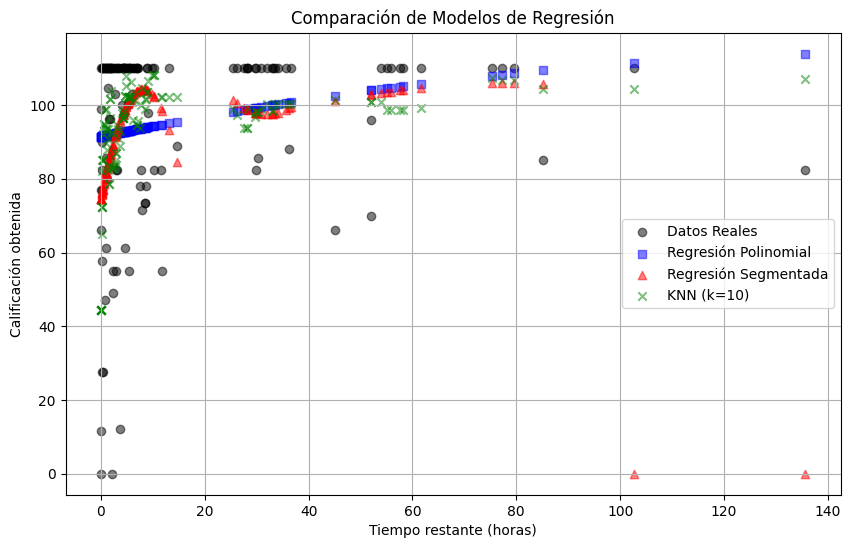

In [33]:
# Crear la gráfica de dispersión con predicciones de los tres modelos
plt.figure(figsize=(10, 6))

# Datos reales
plt.scatter(test["Tiempo"], test["Calificacion"], color='black', alpha=0.5, label="Datos Reales", marker='o')

# Predicciones de Regresión Polinomial
plt.scatter(test["Tiempo"], test_pred, color='blue', alpha=0.5, label="Regresión Polinomial", marker='s')

# Predicciones de Regresión Segmentada
plt.scatter(test["Tiempo"], test_pred_segmentado, color='red', alpha=0.5, label="Regresión Segmentada", marker='^')

# Predicciones de KNN (k=10)
plt.scatter(test["Tiempo"], knn_model.predict(test[["Tiempo"]]), color='green', alpha=0.5, label="KNN (k=10)", marker='x')

# Configuración del gráfico
plt.xlabel("Tiempo restante (horas)")
plt.ylabel("Calificación obtenida")
plt.title("Comparación de Modelos de Regresión")
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


Tras analizar la relación entre el tiempo de entrega y la calificación, encontramos que los modelos de regresión presentan un ajuste débil, lo que sugiere que esta variable no es un predictor fuerte del desempeño académico. KNN con
k=10 resultó ser el modelo con menor error (RSE más bajo), aunque carece de interpretabilidad en comparación con la regresión polinomial. Además, el coeficiente positivo del término lineal en la regresión polinomial sugiere una posible correlación inesperada, lo que indica que podrían existir otros factores más relevantes para predecir la calificación. Para mejorar el análisis, sería recomendable considerar más variables, como el historial del estudiante o el esfuerzo invertido en la tarea.